<a href="https://colab.research.google.com/github/avkornaev/Python-for-image-processing-course/blob/main/Cells_counter_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The algorithm is based on the watershed method. If you want to know more, please check the following links: https://imagej.net/plugins/classic-watershed,
https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

Install libraries. Execute code bellow just once to install the libraries. Then you may comment 'pip' lines using # in the begining of lines of the code.

In [2]:
!pip install czifile
!pip install tifffile
!pip install imagecodecs

     |████████████████████████████████| 30.0 MB 93 kB/s 


Connect to Google disk.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import libraries.

In [4]:
import cv2
import numpy as np
#from scipy.ndimage.interpolation import zoom
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from scipy import ndimage
from skimage import measure, color, io
from skimage.segmentation import clear_border
import czifile
import imagecodecs
#import tifffile

Check the settings.

In [5]:
img_size = (30,30)
img_map = 'Blues' # image map. For example, 'gray','hot','jet','Blues' et al. If you want to know more, please type the following code: help(plt.imshow)
img_path = '/content/drive/MyDrive/Cells_count/'
img_title = 'B16_1122_2_2.czi'

kernel = np.ones((3,3),np.uint8)
numberOfIter = 4 #number of iterations
pixels2microns = 0.396 #scale factor

Download "czi" image and create slices of the image.

In [6]:
img = czifile.imread(img_path + img_title)

img_slice = img[0,0,0,:,0,:,:,0]# image in a form of 3D matrix
img0 = img_slice[0,:,:] # 0 channel that is fluo4-T1 (highlights the apoptosis cells)
img1 = img_slice[1,:,:] # 1 channel that is H3342-T2 (highlights all the cells)

print('CZI image shape: ',img.shape)# ?, ?, ?, number of chanels, x size, y size, ?
print('0 channel shape: ',img0.shape)
print('1 channel shape: ',img1.shape)

CZI image shape:  (1, 1, 1, 2, 1, 3277, 3277, 1)
0 channel shape:  (3277, 3277)
1 channel shape:  (3277, 3277)


Visualize image and its slices

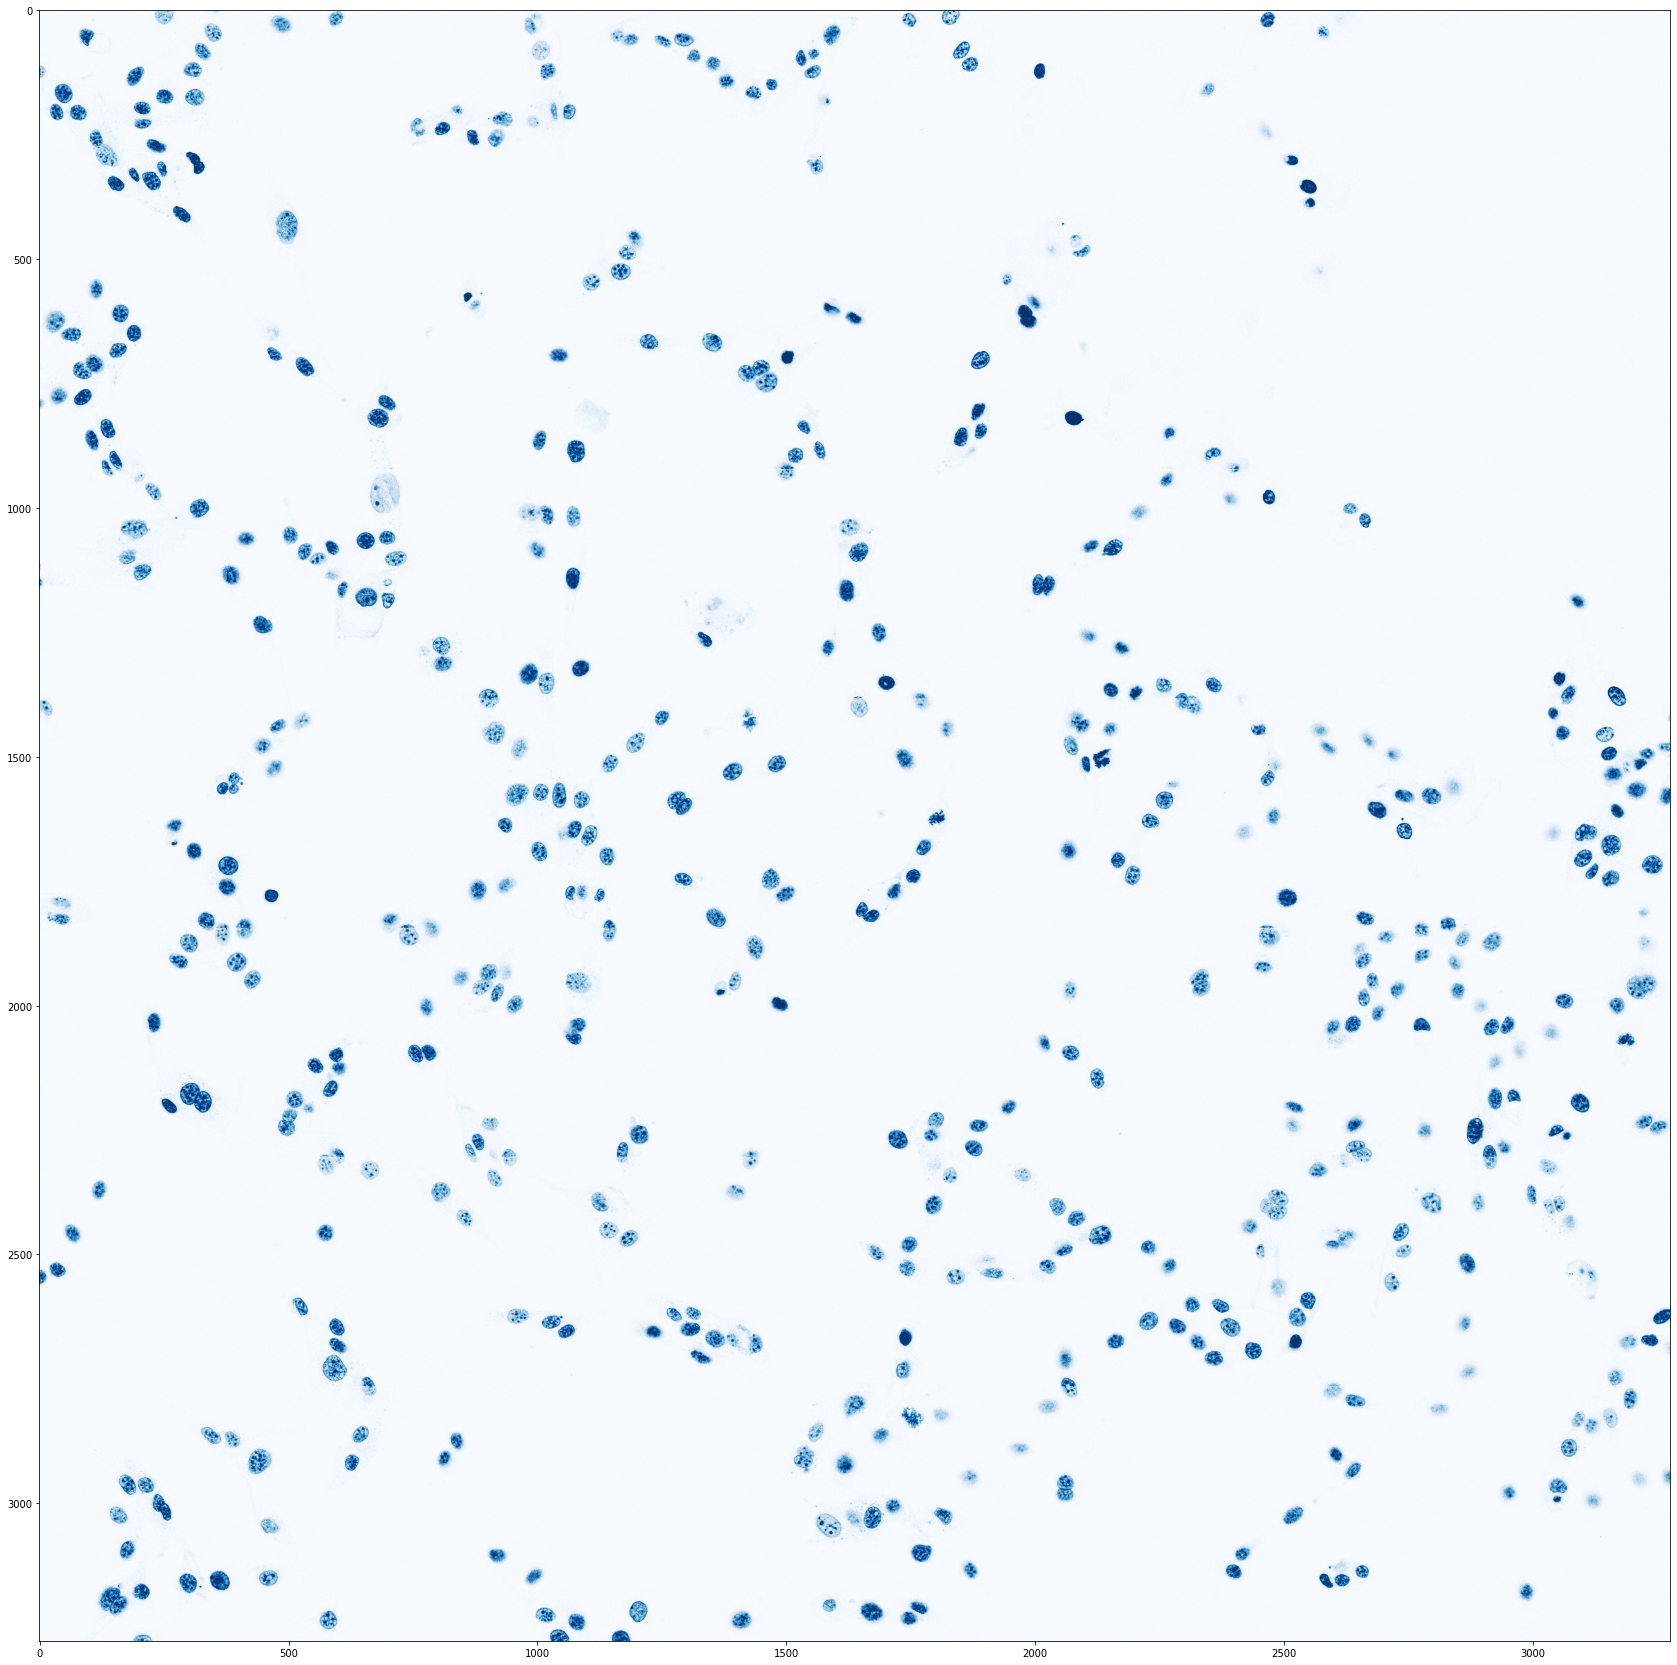

In [7]:
plt.figure(figsize=img_size)
plt.imshow(img1,cmap=img_map)

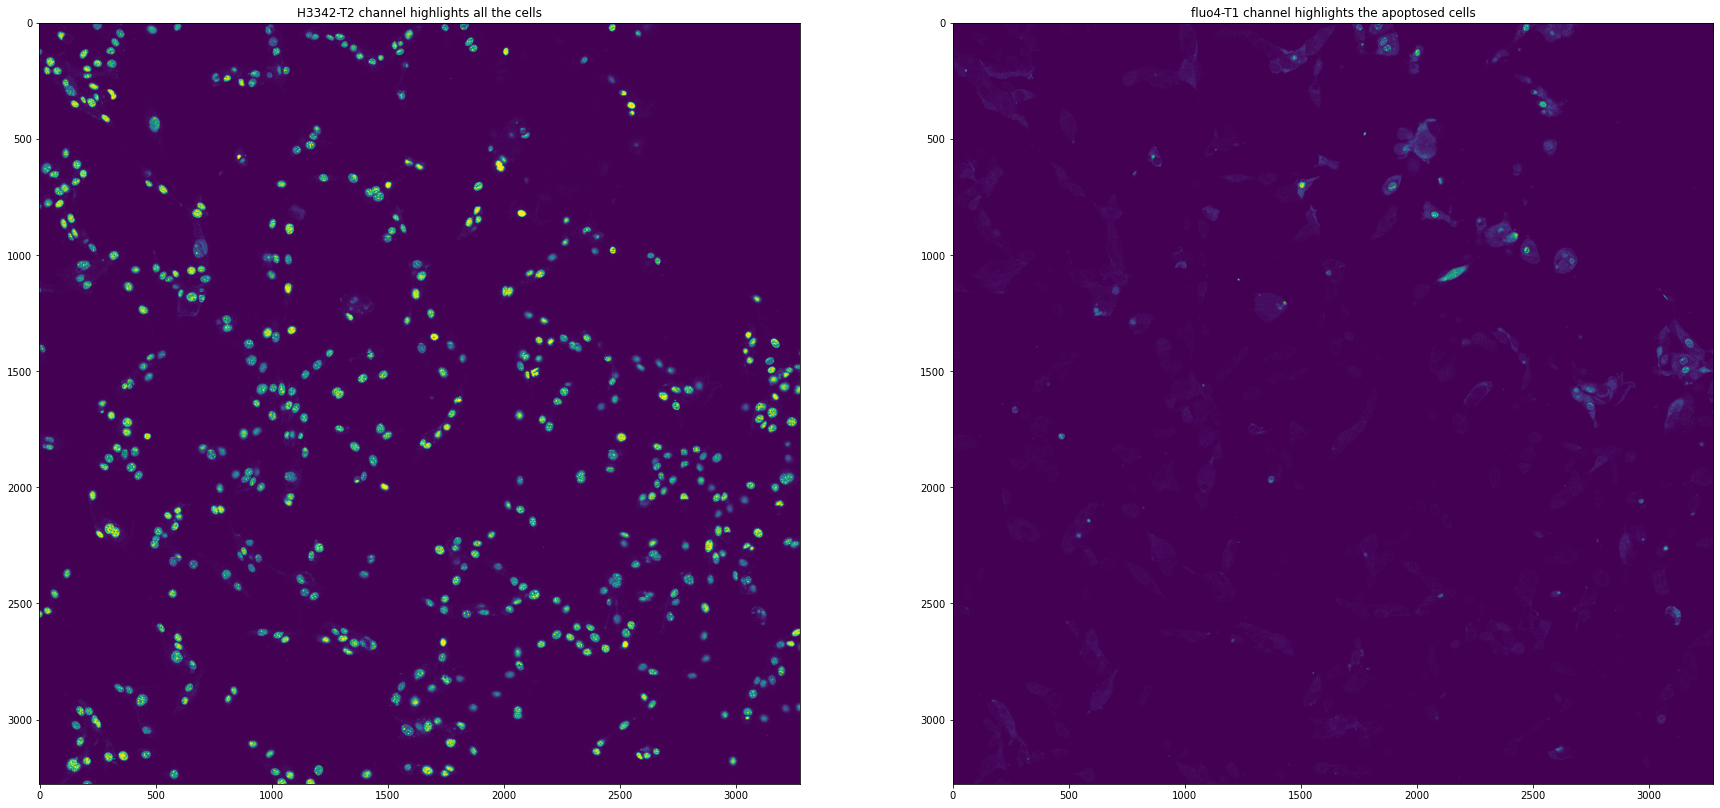

In [8]:
plt.figure(figsize=(img_size[0],img_size[1]/2))
plt.subplot(1,2,1)
plt.title('H3342-T2 channel highlights all the cells')
plt.imshow(img1)

plt.subplot(1,2,2)
plt.title('fluo4-T1 channel highlights the apoptosed cells')
plt.imshow(img0)

Create tepmorary files.

In [9]:
img_path_temp0 = img_path + img_title[0:-4] + '_ch0.jpg' # path 0
img_path_temp1 = img_path + img_title[0:-4] + '_ch1.jpg' # path 1
cv2.imwrite(img_path_temp0, img0) # save img0 in tiff file (temporary file)
cv2.imwrite(img_path_temp1, img1) # save img1 in tiff file (temporary file)
img_path_temp1

'/content/drive/MyDrive/Cells_count/B16_1122_2_2_ch1.jpg'

Visualize the image slices

In [10]:
img1gray = cv2.imread(img_path_temp1,cv2.IMREAD_GRAYSCALE)
#cv2_imshow(img1temp)
print(type(img1gray),img1gray.shape,img1gray.dtype)

<class 'numpy.ndarray'> (3277, 3277) uint8


Threshold image to binary using OTSU. ALl thresholded pixels are set to 255. Then remove noise (opening) and remove edge touching with clear_border function.

In [11]:
ret1, thresh1 = cv2.threshold(img1gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
opening1 = cv2.morphologyEx(thresh1,cv2.MORPH_OPEN,kernel, iterations = numberOfIter)
opening1 = clear_border(opening1)
#cv2_imshow(opening1)
#opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations=1)
#cv2.imshow('Opening Image', thresh)

Identify background and foreground area (OpenCV - Distance Transformation)

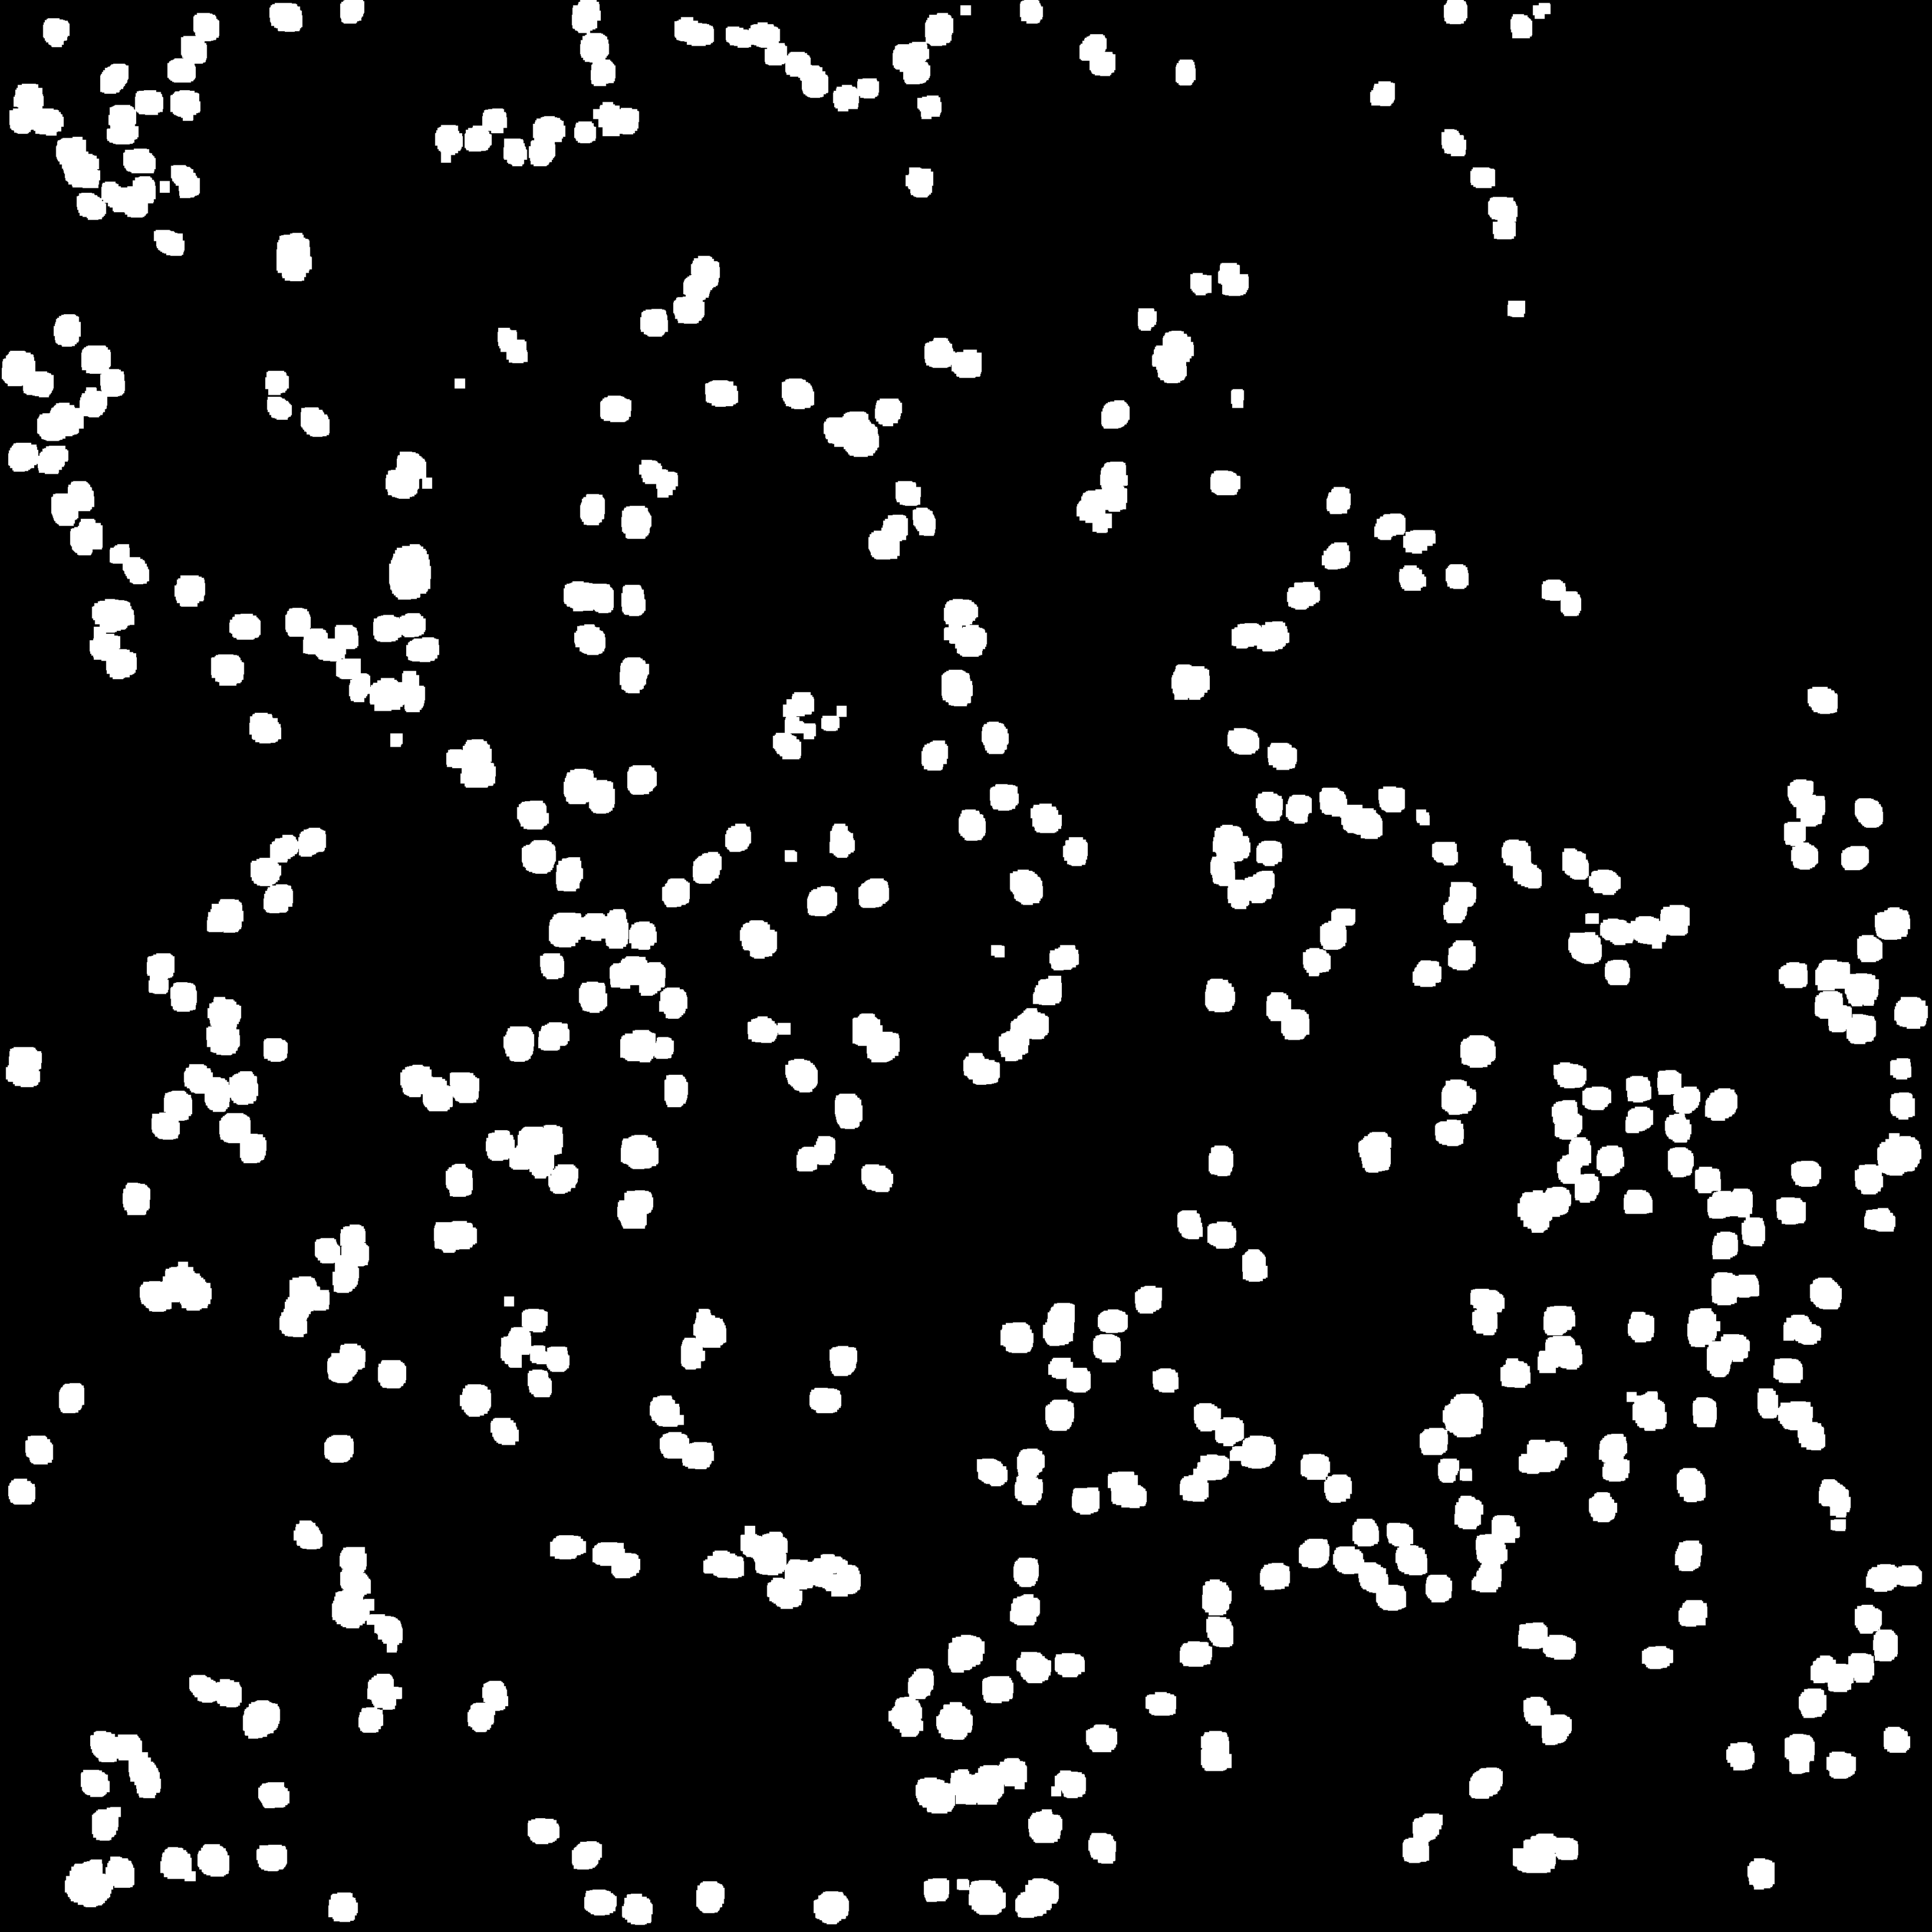

In [12]:
sure_bg1 = cv2.dilate(opening1,kernel,iterations=numberOfIter)
cv2_imshow(sure_bg1)

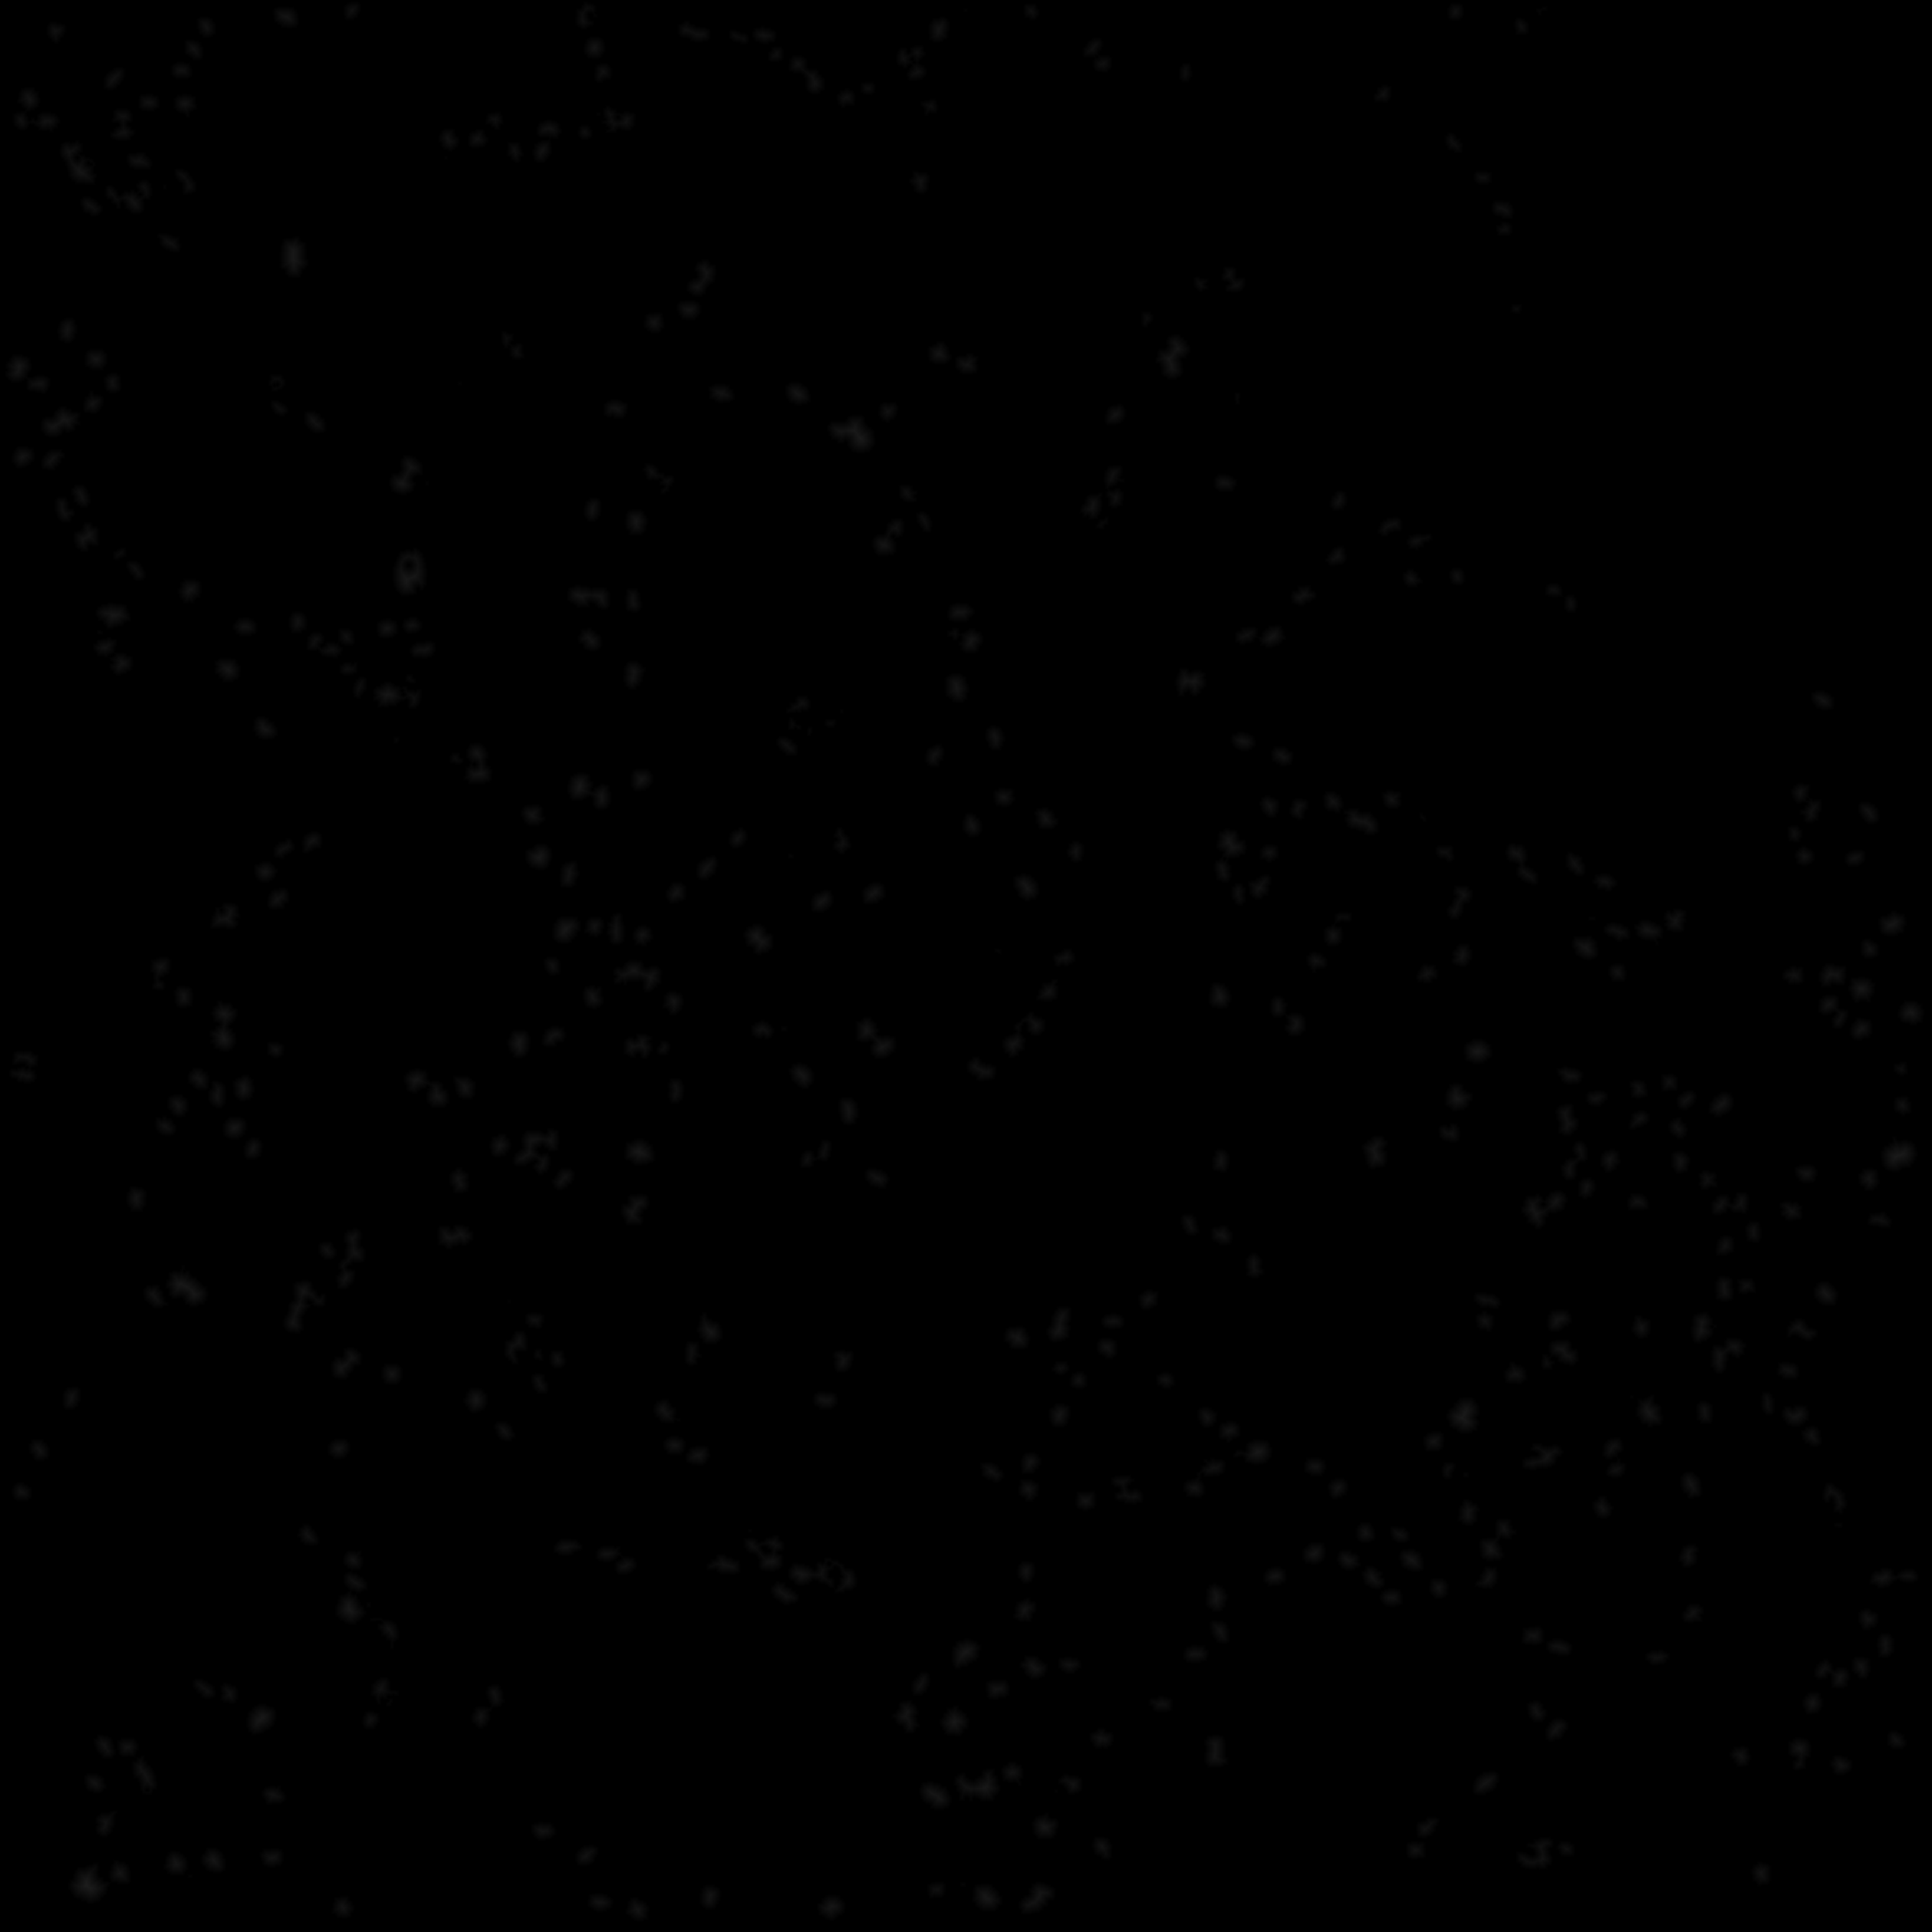

In [13]:
dist_transform1 = cv2.distanceTransform(opening1,cv2.DIST_L2,3)
cv2_imshow(dist_transform1)

In [ ]:
ret2, sure_fg = cv2.threshold(dist_transform1, 0.2*dist_transform1.max(), 255,0)
sure_fg1 = np.uint8(sure_fg)
cv2_imshow(sure_fg1)

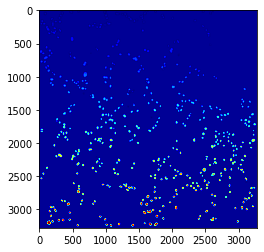

In [20]:
unknown = cv2.subtract(sure_bg1, sure_fg1)
ret3, markers = cv2.connectedComponents(sure_fg1)
markers = markers + 10

markers[unknown==255] = 0
#cv2_imshow(unknown)
plt.imshow(markers, cmap='jet')

In [14]:
#img4 = cv2.imread('/content/drive/MyDrive/Cells_count/B16_1122_2_2.czi')
#img_RGB = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#cv2.imshow('Color picture from opencv',img4)
#edges = cv2.Canny(img3, 100, 200)
#print(img3.shape)